# Librerias & Recursos

In [7]:
%pip install pandas numpy unidecode nltk spacy matplotlib wordcloud scikit-learn

# Descargar el modelo de lenguaje de spaCy
!python -m spacy download en_core_web_sm

%pip install openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.5 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import nltk
import spacy
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
warnings.filterwarnings('ignore')

In [2]:
# Asegurarse de que tengamos los recursos necesarios para NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...


[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
# Install pyarrow for parquet support
%pip install pyarrow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Carga de Datasets

In [2]:
twitter_df = pd.read_csv('Data/Tweet_Post.csv')
twitter_df.head()

,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [8]:
instagram_df = pd.read_excel('Data/Instagram_Post.xlsx')
instagram_df.head()

,Post ID,Post description,Date,Language,Translated Post Description,Sentiment,Hate,Stress or Anxiety
0,CgXDOaQDvGm,“I have decided that the global #monkeypox out...,07/23/2022,English,“I have decided that the global #monkeypox out...,neutral,Not Hate,Stress/Anxiety Detected
1,CgXpRmMIdzG,In light of the evolving monkeypox outbreak wi...,07/23/2022,English,In light of the evolving monkeypox outbreak wi...,neutral,Not Hate,Stress/Anxiety Detected
2,CgXMyIjP34S,#LinkInBio | The World Health Organization sai...,07/23/2022,English,#LinkInBio | The World Health Organization sai...,fear,Not Hate,Stress/Anxiety Detected
3,CgXaFGDsevq,If you've been hearing about monkeypox and wan...,07/23/2022,English,If you've been hearing about monkeypox and wan...,neutral,Not Hate,No Stress/Anxiety Detected
4,CgX3rATJTXd,Our horrific experience with MONKEYPOX…\n\n#mo...,07/23/2022,English,Our horrific experience with MONKEYPOX…\n\n#mo...,fear,Not Hate,Stress/Anxiety Detected


In [3]:
# cargar dataset parquet en pandas
parquet_file = pd.read_parquet('Data/test-00000-of-00001-d161e0d7d20a9b0a.parquet')
reddit_df = pd.DataFrame(parquet_file)
reddit_df.head()

,text,label
0,Un agradable paseo por el casco antiguo de la ...,5
1,Gran llegar entrada procedente Gran ciudad en ...,4
2,Sencillamente Espectacular Para Caminarlo o en...,5
3,Monserrate y sus bellas vistas Es una visita o...,5
4,Un paraiso muy cerca de la ciudad de Mérida El...,5


# Pre procesamiento

## Combinar datasets y estandarizar etiquetas de sentimentos

In [4]:
# Select relevant columns from Twitter dataset
twitter_selected = twitter_df[['text', 'date', 'sentiment']].copy()
twitter_selected.rename(columns={'text': 'post'}, inplace=True)
twitter_selected['source'] = 'Twitter'
twitter_selected.head()

,post,date,sentiment,source
0,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",scared,Twitter
1,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",scared,Twitter
2,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",scared,Twitter
3,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",scared,Twitter
4,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",scared,Twitter


In [ ]:
# Select relevant columns from Instagram dataset where 'Language' is Spanish

# Filter Instagram dataset to only include Spanish posts
instagram_df = instagram_df[instagram_df['Language'] == 'Spanish']

instagram_selected = instagram_df[['Post description', 'Date', 'Sentiment']].copy()
instagram_selected.rename(columns={'Post description': 'post', 'Date': 'date', 'Sentiment': 'sentiment'}, inplace=True)
instagram_selected['source'] = 'Instagram'
instagram_selected.head()

In [6]:
travel_selected = reddit_df.copy()
travel_selected.rename(columns={'text': 'post', 'label': 'sentiment'}, inplace=True)
travel_selected['date'] = pd.Timestamp('today')  # No hay fecha, asignamos la fecha actual
travel_selected['source'] = 'Review'
travel_selected.head()

,post,sentiment,date,source
0,Un agradable paseo por el casco antiguo de la ...,5,2025-03-22 01:34:16.360265,Review
1,Gran llegar entrada procedente Gran ciudad en ...,4,2025-03-22 01:34:16.360265,Review
2,Sencillamente Espectacular Para Caminarlo o en...,5,2025-03-22 01:34:16.360265,Review
3,Monserrate y sus bellas vistas Es una visita o...,5,2025-03-22 01:34:16.360265,Review
4,Un paraiso muy cerca de la ciudad de Mérida El...,5,2025-03-22 01:34:16.360265,Review


In [87]:
travel_selected.shape

(274649, 4)

In [7]:
travel_selected.shape

(25171, 4)

In [8]:
# 2 registros del dataset de la columna post, donde sentiment = 1, que se vea completo la columna post
display(travel_selected['post'][travel_selected['sentiment'] == 1].head(2))
display(travel_selected[travel_selected['sentiment'] == 2].head(2))
display(travel_selected[travel_selected['sentiment'] == 3].head(2))
display(travel_selected[travel_selected['sentiment'] == 4].head(2))
display(travel_selected[travel_selected['sentiment'] == 5].head(2))


43    Pésima opción entre servicio e instalaciones N...
79    Aburrido Me enteré a través del museo entero c...
Name: post, dtype: object

,post,sentiment,date,source
11,"Buena comida, pero ten paciencia Este fue el p...",2,2025-03-22 01:34:16.360265,Review
87,"horrible sucio, descuidado, abandonado, muy fe...",2,2025-03-22 01:34:16.360265,Review


,post,sentiment,date,source
9,Información poco clara. Lugar agradable Cierra...,3,2025-03-22 01:34:16.360265,Review
19,Comida decepcionante Reservamos una mesa aquí ...,3,2025-03-22 01:34:16.360265,Review


,post,sentiment,date,source
1,Gran llegar entrada procedente Gran ciudad en ...,4,2025-03-22 01:34:16.360265,Review
8,Buen hotel para negocios La ubicacion del hote...,4,2025-03-22 01:34:16.360265,Review


,post,sentiment,date,source
0,Un agradable paseo por el casco antiguo de la ...,5,2025-03-22 01:34:16.360265,Review
2,Sencillamente Espectacular Para Caminarlo o en...,5,2025-03-22 01:34:16.360265,Review


In [9]:
# Mapear los sentimientos según el modelo de Plutchik
    # Plutchik tiene 8 emociones básicas: alegría, confianza, miedo, sorpresa, tristeza, disgusto, ira, anticipación
plutchik_mapping = {
    # Twitter emotions
    'scared': 'miedo',
    'sad': 'tristeza',
    'powerful': 'confianza',
    'peaceful': 'serenidad',  # Podría mapearse a "confianza" en un nivel menor de intensidad
    'mad': 'ira',
    'joyful': 'alegría',
    
    # Instagram emotions
    #'fear': 'miedo',
    #'anger': 'ira',
    #'disgust': 'disgusto',
    #'joy': 'alegría',
    #'neutral': 'neutral',     # No es una de las 8 básicas de Plutchik, pero podemos mantenerla
    #'sadness': 'tristeza',
    #'surprise': 'sorpresa',

    # Hotel ratings (1-5)
    1: 'ira',      # Rating 1: Muy negativo, muestra ira/enojo
    2: 'disgusto',    # Rating 2: Negativo, muestra disgusto
    3: 'neutral',    # Rating 3: Mixto o neutral
    4: 'alegría',        # Rating 4: Positivo, muestra alegría
    5: 'confianza'       # Rating 5: Muy positivo, muestra confianza/admiración
}

# Apply the mapping to standardize sentiment labels
twitter_selected['plutchik_sentiment'] = twitter_selected['sentiment'].map(plutchik_mapping)
#instagram_selected['plutchik_sentiment'] = instagram_selected['sentiment'].map(plutchik_mapping)
travel_selected['plutchik_sentiment'] = travel_selected['sentiment'].map(plutchik_mapping)

# Check the mapping results
print("\nTwitter Sentiment Mapping Results:")
print(twitter_selected[['sentiment', 'plutchik_sentiment']].value_counts())
#print("\nInstagram Sentiment Mapping Results:")
#print(instagram_selected[['sentiment', 'plutchik_sentiment']].value_counts())
print("\nHotel Rating to Plutchik Sentiment Mapping:")
print(travel_selected[['sentiment', 'plutchik_sentiment']].value_counts())


Twitter Sentiment Mapping Results:
sentiment  plutchik_sentiment
peaceful   serenidad             660
mad        ira                   530
powerful   confianza             420
sad        tristeza              360
joyful     alegría               350
scared     miedo                 270
Name: count, dtype: int64

Hotel Rating to Plutchik Sentiment Mapping:
sentiment  plutchik_sentiment
5          confianza             15710
4          alegría                6023
3          neutral                2166
2          disgusto                695
1          ira                     577
Name: count, dtype: int64


In [10]:
# Merge los dos datasets
merged_df = pd.concat([twitter_selected, travel_selected], ignore_index=True)

# Convert date to consistent format
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# Sort by date
merged_df.sort_values('date', inplace=True)

# Reset index
merged_df.reset_index(drop=True, inplace=True)

# Check the merged dataset
print("\nMerged Dataset Information:")
print(merged_df.info())
print("\nMerged Dataset Preview:")
merged_df.head()


Merged Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27761 entries, 0 to 27760
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   post                27761 non-null  object        
 1   date                25171 non-null  datetime64[ns]
 2   sentiment           27761 non-null  object        
 3   source              27761 non-null  object        
 4   plutchik_sentiment  27761 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.1+ MB
None

Merged Dataset Preview:


,post,date,sentiment,source,plutchik_sentiment
0,Un agradable paseo por el casco antiguo de la ...,2025-03-22 01:34:16.360265,5,Review,confianza
1,Muy alegre por las noches y pintoresco en el d...,2025-03-22 01:34:16.360265,5,Review,confianza
2,Tome un selfie con 10 personas m! No deberían ...,2025-03-22 01:34:16.360265,5,Review,confianza
3,Para entender a los precolombinos Imprescindib...,2025-03-22 01:34:16.360265,4,Review,alegría
4,Sin duda volvería al mismo hotel con los ojos ...,2025-03-22 01:34:16.360265,5,Review,confianza


## Funciones

In [12]:
def normalize_text(text):
    """
    Normalize text by:
    1. Removing special characters (keeping Spanish letters and accents)
    2. Removing words with characters repeated more than twice
    3. Joining hyphenated words
    4. Converting to lowercase
    5. Removing tildes and the letter "ñ"
    """
    if not isinstance(text, str):
        return ""
    
    # Remove tildes and the letter "ñ" using unidecode
    text = unidecode(text)
    
    # Remove special characters (keeping only letters and spaces)
    letters_only = re.sub(r"[^A-Za-z\s]", " ", text)
    
    # Remove repeated characters (more than 2 times)
    no_repeats = re.sub(r"(.)\1{2,}", r"\1\1", letters_only)
    
    # Join hyphenated words
    no_hyphens = re.sub(r"([A-Za-z]+)-([A-Za-z]+)", r"\1\2", no_repeats)
    
    # Convert to lowercase
    lowercase = no_hyphens.lower()
    
    # Remove extra whitespace
    cleaned = re.sub(r"\s+", " ", lowercase).strip()
    
    return cleaned

In [13]:
merged_df['normalized_text'] = merged_df['post'].apply(normalize_text)
print("\nEjemplos Normalizacion:")
for i in range(min(5, len(merged_df))):
    print(f"Original: {merged_df.loc[i, 'post']}")
    print(f"Normalizado: {merged_df.loc[i, 'normalized_text']}")
    print("-" * 50)


Ejemplos Normalizacion:
Original: Un agradable paseo por el casco antiguo de la ciudad Es imprescindible visitar esta parte de la ciudad donde encontrará la catedral y los edificios gubernamentales nuevos muy agradable de visitar durante las horas de la mañana
Normalizado: un agradable paseo por el casco antiguo de la ciudad es imprescindible visitar esta parte de la ciudad donde encontrara la catedral y los edificios gubernamentales nuevos muy agradable de visitar durante las horas de la manana
--------------------------------------------------
Original: Muy alegre por las noches y pintoresco en el día Es uno de los puntos obligados en la visita a la ciudad capital de Guanajuato Ya que en el día es una zona muy pintoresca y tradicional con la arquitectura colonial además que por las noches es muy alegre sus Terrazas y los diferentes grupos de música que asisten.
Normalizado: muy alegre por las noches y pintoresco en el dia es uno de los puntos obligados en la visita a la ciudad capit

In [14]:
def tokenize_text(text):
    """
    Tokenize text into individual words
    """
    if not isinstance(text, str) or not text:
        return []
    
    tokens = word_tokenize(text)
    return tokens

In [15]:
# Apply tokenization to the normalized text
merged_df['tokens'] = merged_df['normalized_text'].apply(tokenize_text)

# Show examples of tokenization
print("\nEjemplo Tokenizacion:")
for i in range(min(5, len(merged_df))):
    print(f"Normalized: {merged_df.loc[i, 'normalized_text']}")
    print(f"Tokens: {merged_df.loc[i, 'tokens']}")
    print("-" * 50)


Ejemplo Tokenizacion:
Normalized: un agradable paseo por el casco antiguo de la ciudad es imprescindible visitar esta parte de la ciudad donde encontrara la catedral y los edificios gubernamentales nuevos muy agradable de visitar durante las horas de la manana
Tokens: ['un', 'agradable', 'paseo', 'por', 'el', 'casco', 'antiguo', 'de', 'la', 'ciudad', 'es', 'imprescindible', 'visitar', 'esta', 'parte', 'de', 'la', 'ciudad', 'donde', 'encontrara', 'la', 'catedral', 'y', 'los', 'edificios', 'gubernamentales', 'nuevos', 'muy', 'agradable', 'de', 'visitar', 'durante', 'las', 'horas', 'de', 'la', 'manana']
--------------------------------------------------
Normalized: muy alegre por las noches y pintoresco en el dia es uno de los puntos obligados en la visita a la ciudad capital de guanajuato ya que en el dia es una zona muy pintoresca y tradicional con la arquitectura colonial ademas que por las noches es muy alegre sus terrazas y los diferentes grupos de musica que asisten
Tokens: ['muy',

In [16]:
def remove_stopwords(tokens):
    """
    Remove Spanish stopwords from a list of tokens
    """
    if not tokens:
        return []
    
    spanish_stopwords = set(stopwords.words('spanish'))
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    return filtered_tokens

In [17]:
# Apply stopword removal to the tokens
merged_df['filtered_tokens'] = merged_df['tokens'].apply(remove_stopwords)

# Show examples of stopword removal
print("\nEjemplos Remocion Stopword:")
for i in range(min(5, len(merged_df))):
    print(f"Tokens: {merged_df.loc[i, 'tokens']}")
    print(f"Despues de remover Stopword: {merged_df.loc[i, 'filtered_tokens']}")
    print("-" * 50)


Ejemplos Remocion Stopword:
Tokens: ['un', 'agradable', 'paseo', 'por', 'el', 'casco', 'antiguo', 'de', 'la', 'ciudad', 'es', 'imprescindible', 'visitar', 'esta', 'parte', 'de', 'la', 'ciudad', 'donde', 'encontrara', 'la', 'catedral', 'y', 'los', 'edificios', 'gubernamentales', 'nuevos', 'muy', 'agradable', 'de', 'visitar', 'durante', 'las', 'horas', 'de', 'la', 'manana']
Despues de remover Stopword: ['agradable', 'paseo', 'casco', 'antiguo', 'ciudad', 'imprescindible', 'visitar', 'parte', 'ciudad', 'encontrara', 'catedral', 'edificios', 'gubernamentales', 'nuevos', 'agradable', 'visitar', 'horas', 'manana']
--------------------------------------------------
Tokens: ['muy', 'alegre', 'por', 'las', 'noches', 'y', 'pintoresco', 'en', 'el', 'dia', 'es', 'uno', 'de', 'los', 'puntos', 'obligados', 'en', 'la', 'visita', 'a', 'la', 'ciudad', 'capital', 'de', 'guanajuato', 'ya', 'que', 'en', 'el', 'dia', 'es', 'una', 'zona', 'muy', 'pintoresca', 'y', 'tradicional', 'con', 'la', 'arquitectura'

In [18]:
try:
    nlp = spacy.load('es_core_news_sm')
except:
    # If model not found, download it
    import sys
    !{sys.executable} -m spacy download es_core_news_sm
    nlp = spacy.load('es_core_news_sm')

def lemmatize_tokens(tokens):
    """
    Lemmatize a list of tokens using spaCy's Spanish model
    """
    if not tokens:
        return []
    
    # Join tokens back into text for spaCy processing
    text = ' '.join(tokens)
    doc = nlp(text)
    
    # Extract lemmas
    lemmas = [token.lemma_.lower() for token in doc if token.lemma_.strip()]
    
    return lemmas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 55.9 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
# Inicializar el lematizador de NLTK
# lemmatizer = WordNetLemmatizer()

# # Función para convertir etiquetas POS de NLTK a WordNet
# def get_wordnet_pos(treebank_tag):
#     """
#     Mapea las etiquetas POS de NLTK a las etiquetas POS de WordNet.
#     """
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN  # Por defecto, asumimos sustantivo

# def lemmatize_tokens(tokens):
#     """
#     Lemmatiza una lista de tokens usando NLTK.
#     """
#     if not tokens:
#         return []
    
#     # Obtener las etiquetas POS de los tokens
#     pos_tags = nltk.pos_tag(tokens)
    
#     # Lematizar cada token con su etiqueta POS correspondiente
#     lemmas = []
#     for token, pos_tag in pos_tags:
#         wordnet_pos = get_wordnet_pos(pos_tag)
#         lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
#         lemmas.append(lemma.lower())
    
#     return lemmas

In [19]:
# Apply lemmatization to the filtered tokens
merged_df['lemmas'] = merged_df['filtered_tokens'].apply(lemmatize_tokens)

# Show examples of lemmatization
print("\nEjemplos Lemmatizacion:")
for i in range(min(5, len(merged_df))):
    print(f"Tokens: {merged_df.loc[i, 'filtered_tokens']}")
    print(f"Lemmas: {merged_df.loc[i, 'lemmas']}")
    print("-" * 50)


Ejemplos Lemmatizacion:
Tokens: ['agradable', 'paseo', 'casco', 'antiguo', 'ciudad', 'imprescindible', 'visitar', 'parte', 'ciudad', 'encontrara', 'catedral', 'edificios', 'gubernamentales', 'nuevos', 'agradable', 'visitar', 'horas', 'manana']
Lemmas: ['agradable', 'paseo', 'casco', 'antiguo', 'ciudad', 'imprescindible', 'visitar', 'parte', 'ciudad', 'encontrara', 'catedral', 'edificio', 'gubernamental', 'nuevo', 'agradable', 'visitar', 'hora', 'manán']
--------------------------------------------------
Tokens: ['alegre', 'noches', 'pintoresco', 'dia', 'puntos', 'obligados', 'visita', 'ciudad', 'capital', 'guanajuato', 'dia', 'zona', 'pintoresca', 'tradicional', 'arquitectura', 'colonial', 'ademas', 'noches', 'alegre', 'terrazas', 'diferentes', 'grupos', 'musica', 'asisten']
Lemmas: ['alegre', 'noche', 'pintoresco', 'dia', 'punto', 'obligado', 'visita', 'ciudad', 'capital', 'guanajuato', 'dia', 'zona', 'pintoresco', 'tradicional', 'arquitectura', 'colonial', 'adema', 'noche', 'alegre'

In [20]:
# Combine lemmas into a clean text column
merged_df['clean_text'] = merged_df['lemmas'].apply(lambda x: ' '.join(x) if x else '')


Generating Word Cloud for All Texts:


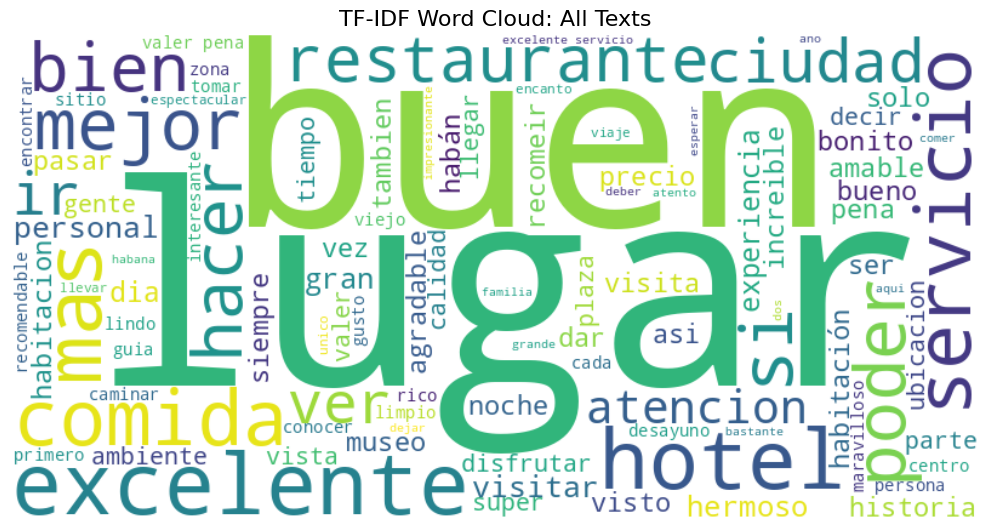

In [21]:
# Create a TF-IDF word cloud for each sentiment category

# Create a function to generate word clouds from TF-IDF values
def generate_tfidf_wordcloud(texts, title, max_words=100):
    """
    Generate a word cloud based on TF-IDF values for a collection of texts
    """
    # Create a TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words=stopwords.words('spanish'),
        ngram_range=(1, 2)  # Include both single words and bigrams
    )
    
    # Fit and transform the texts
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    
    # Get feature names and their TF-IDF scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Sum TF-IDF values across documents for each word
    tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
    
    # Create a dictionary of word -> TF-IDF score
    word_tfidf = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
    
    # Create and display word cloud
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        contour_width=1,
        contour_color='steelblue'
    ).generate_from_frequencies(word_tfidf)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate a word cloud for all texts
print("\nGenerating Word Cloud for All Texts:")
all_texts = merged_df['clean_text'].dropna().tolist()
generate_tfidf_wordcloud(all_texts, 'TF-IDF Word Cloud: All Texts')


Generating Word Clouds by Sentiment Category:


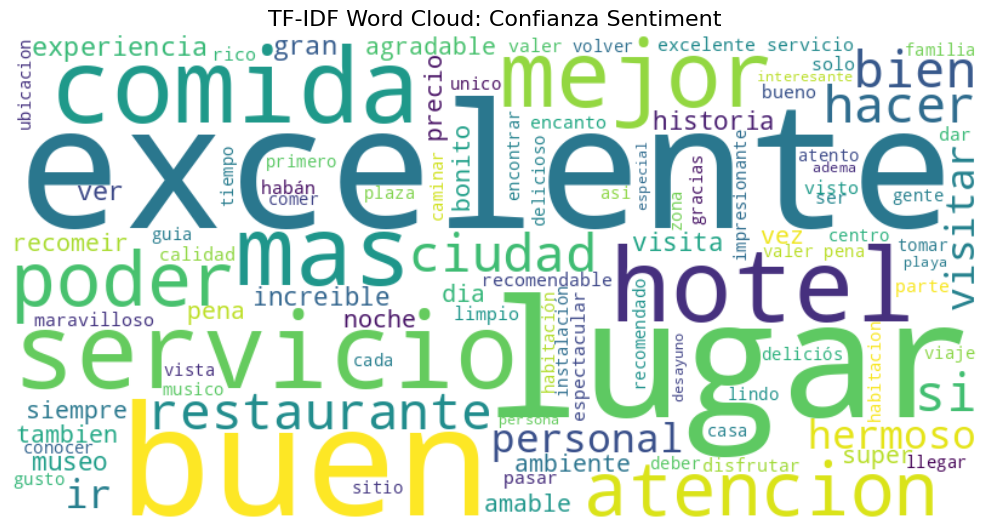

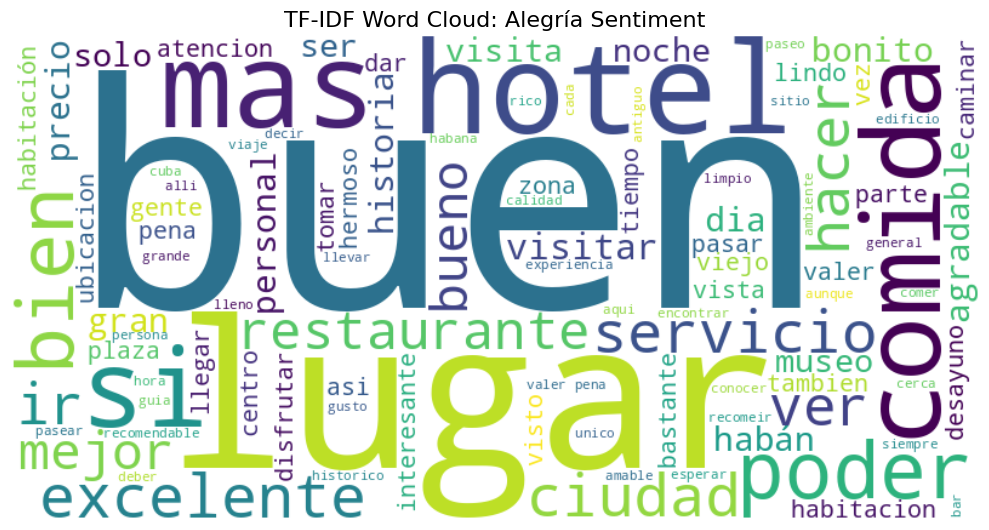

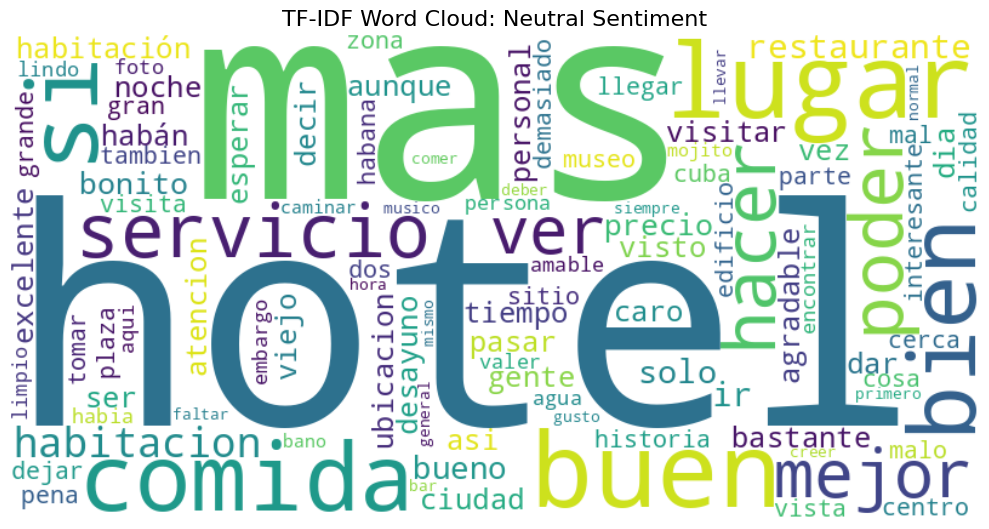

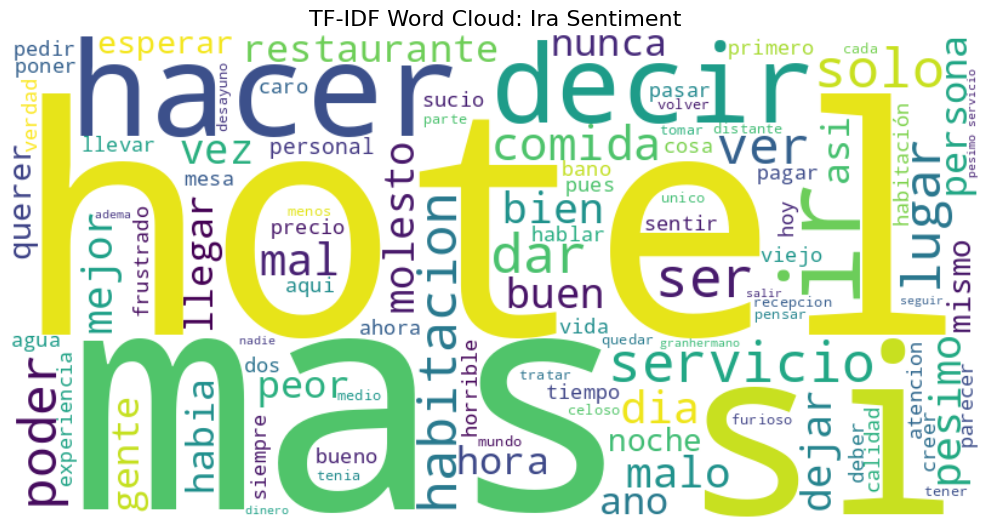

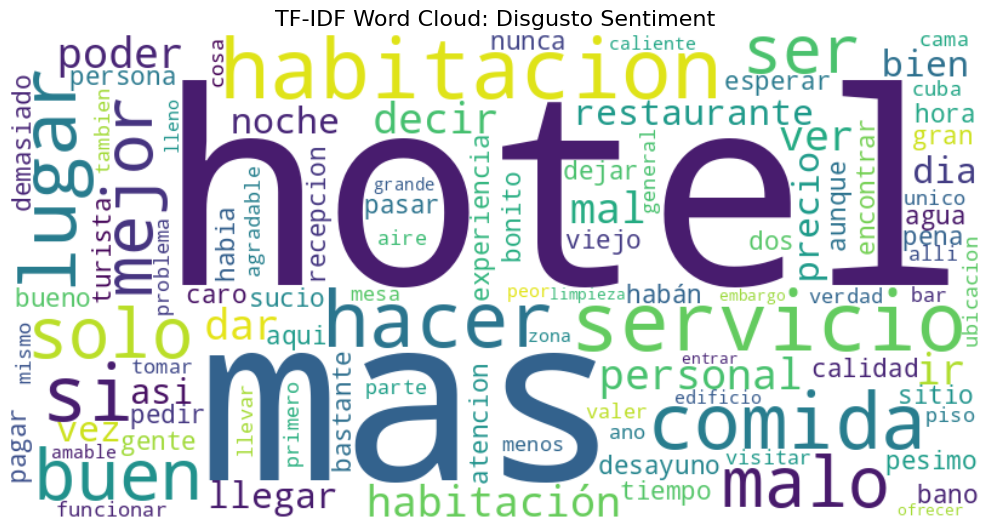

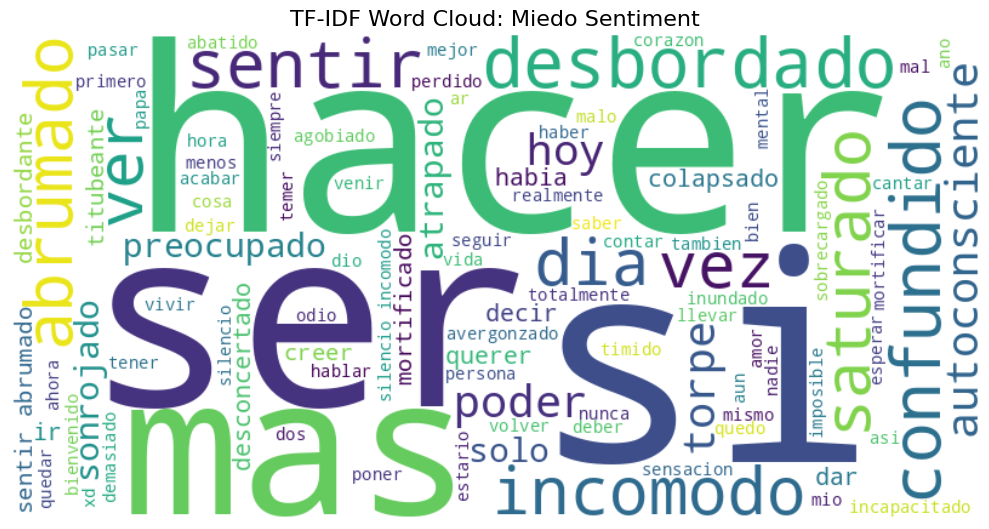

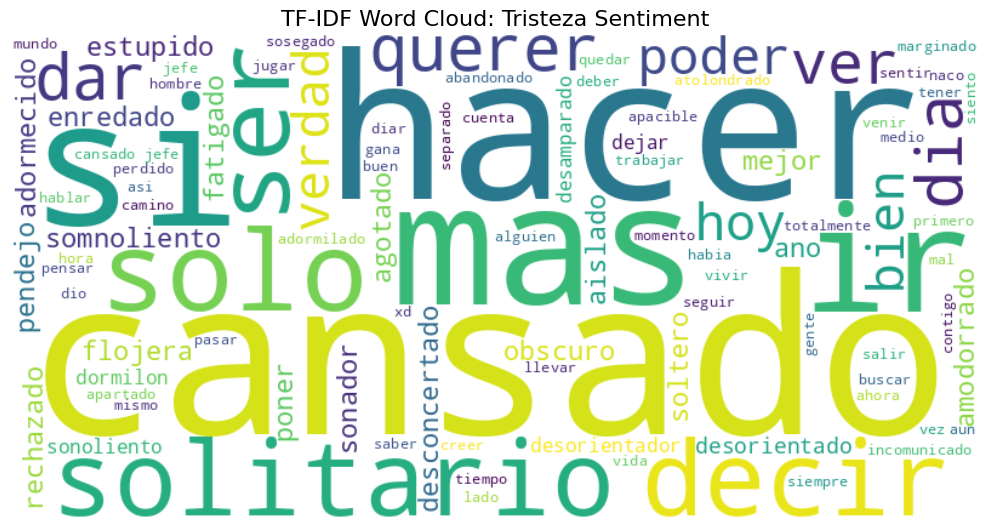

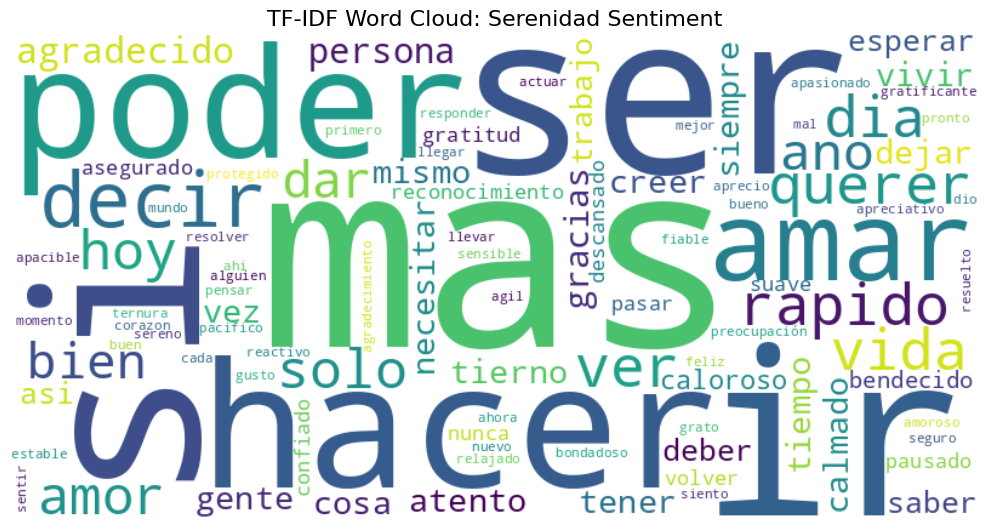

In [22]:
# Generate word clouds for each sentiment category
print("\nGenerating Word Clouds by Sentiment Category:")
for sentiment in merged_df['plutchik_sentiment'].dropna().unique():
    sentiment_texts = merged_df[merged_df['plutchik_sentiment'] == sentiment]['clean_text'].dropna().tolist()
    if sentiment_texts:
        generate_tfidf_wordcloud(sentiment_texts, f'TF-IDF Word Cloud: {sentiment.title()} Sentiment')

In [23]:
# Final processed dataset summary
print("\nResumen Final")
print(f"Numero total de post: {len(merged_df)}")
print(f"Numero de post por fuente: {merged_df['source'].value_counts().to_dict()}")
print(f"Numero de post por sentimiento: {merged_df['plutchik_sentiment'].value_counts().to_dict()}")
print(f"Rango Fechas: {merged_df['date'].min()} to {merged_df['date'].max()}")


Resumen Final
Numero total de post: 27761
Numero de post por fuente: {'Review': 25171, 'Twitter': 2590}
Numero de post por sentimiento: {'confianza': 16130, 'alegría': 6373, 'neutral': 2166, 'ira': 1107, 'disgusto': 695, 'serenidad': 660, 'tristeza': 360, 'miedo': 270}
Rango Fechas: 2025-03-22 01:34:16.360265 to 2025-03-22 01:34:16.360265


In [79]:
# Save the processed dataset to a CSV file
processed_file_path = 'Data/processed_sentiment_data.csv'
merged_df.to_csv(processed_file_path, index=False)
print(f"\nGuardado como: {processed_file_path}")


Guardado como: Data/processed_sentiment_data.csv


In [24]:
merged_df.head()

,post,date,sentiment,source,plutchik_sentiment,normalized_text,tokens,filtered_tokens,lemmas,clean_text
0,Un agradable paseo por el casco antiguo de la ...,2025-03-22 01:34:16.360265,5,Review,confianza,un agradable paseo por el casco antiguo de la ...,"[un, agradable, paseo, por, el, casco, antiguo...","[agradable, paseo, casco, antiguo, ciudad, imp...","[agradable, paseo, casco, antiguo, ciudad, imp...",agradable paseo casco antiguo ciudad imprescin...
1,Muy alegre por las noches y pintoresco en el d...,2025-03-22 01:34:16.360265,5,Review,confianza,muy alegre por las noches y pintoresco en el d...,"[muy, alegre, por, las, noches, y, pintoresco,...","[alegre, noches, pintoresco, dia, puntos, obli...","[alegre, noche, pintoresco, dia, punto, obliga...",alegre noche pintoresco dia punto obligado vis...
2,Tome un selfie con 10 personas m! No deberían ...,2025-03-22 01:34:16.360265,5,Review,confianza,tome un selfie con personas m no deberian visi...,"[tome, un, selfie, con, personas, m, no, deber...","[tome, selfie, personas, m, deberian, visitar,...","[tomar, selfie, persona, m, deberiar, visitar,...",tomar selfie persona m deberiar visitar bogota...
3,Para entender a los precolombinos Imprescindib...,2025-03-22 01:34:16.360265,4,Review,alegría,para entender a los precolombinos imprescindib...,"[para, entender, a, los, precolombinos, impres...","[entender, precolombinos, imprescindible, pase...","[entender, precolombinos, imprescindible, pase...",entender precolombinos imprescindible paseo sa...
4,Sin duda volvería al mismo hotel con los ojos ...,2025-03-22 01:34:16.360265,5,Review,confianza,sin duda volveria al mismo hotel con los ojos ...,"[sin, duda, volveria, al, mismo, hotel, con, l...","[duda, volveria, mismo, hotel, ojos, cerrados,...","[duda, volverio, mismo, hotel, ojo, cerrado, h...",duda volverio mismo hotel ojo cerrado hotel re...
